# Expected goals (xG) modeling 
In this Jupyter notebook, we'll create an expected-goals model, utilizing widely-recognized data science and machine learning tools such as Pandas, XGBoost, and scikit-learn. Throughout this guide, we'll cover the following stages:

-  Data Loading
- Data Preparation
- Generating Examples and Datasets
- Model Training
- Model Evaluation

### *Imports*

In [1]:
import os
import warnings
import pandas as pd 
from scipy.spatial import distance


from xgboost import XGBClassifier
from sklearn.metrics import average_precision_score, roc_auc_score
from sklearn.model_selection import GridSearchCV, train_test_split

from scikitplot.metrics import plot_roc_curve
from scikitplot.metrics import plot_calibration_curve
from scikitplot.metrics import plot_precision_recall_curve

pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")

##  *Dataset Overview*

The dataset used in this project, provided by Sci-Sports, contains information about 127,643 soccer simiulated shots. Each record in this dataset provides comprehensive characteristics about the shot and the two actions that immediately preceded it, including:

- **game_id**: a unique identifier for the football match.
- **team_id**: a unique identifier for the team responsible for the action.
- **player_id**: a unique identifier for the player executing the action.
- **period**: an indicator of whether the action took place in the first half (1) or the second half (2) of the game.
- **seconds**: the time elapsed in seconds since the start of the respective half.
- **type_id**: a numerical code representing the type of action.
- **type_name**: the descriptive name associated with the action type.
- **body_part_id**: indicates whether the action involved the foot (0), head (1), or another body part (2).
- **result**: a value of 0 indicates an unsuccessful action, while 1 signifies a successful one.
- **start_x**: the x-coordinate denoting the starting position of the action, with values ranging from 0 to 105.
- **start_y**: the y-coordinate indicating the starting location, ranging from 0 to 68.
- **end_x**: the x-coordinate marking the ending location of the action, also within the range of 0 to 105.
- **end_y**: the y-coordinate specifying the ending position, similarly within the 0 to 68 range.

Note that the prefix "action" is used to represent the shot, while "action1" and "action2" pertain to the actions immediately preceding the shot. 


In [2]:
shots_df= pd.read_parquet('data/shots/scisports-shots.parquet')
shots_df.head()

,action_game_id,action_team_id,action_player_id,action_period,action_seconds,action_type_name,action_body_part_id,action_result,action_start_x,action_start_y,action_end_x,action_end_y,action1_game_id,action1_team_id,action1_player_id,action1_period,action1_seconds,action1_type_name,action1_body_part_id,action1_result,action1_start_x,action1_start_y,action1_end_x,action1_end_y,action2_game_id,action2_team_id,action2_period,action2_seconds,action2_type_id,action2_type_name,action2_body_part_id,action2_result,action2_start_x,action2_start_y,action2_end_x,action2_end_y
0,0,6,5703,1,188.23,shot,0,0,98.75,40.17,105.0,40.85,0.0,6.0,3726.0,1.0,187.75,cross,0.0,1.0,99.28,49.54,99.28,40.70,0.0,6.0,1.0,185.62,0.0,pass,0.0,1.0,93.53,65.36,98.78,49.04
1,0,6,3726,1,609.31,shot,0,0,84.20,48.48,105.0,27.40,0.0,6.0,5797.0,1.0,607.57,pass,0.0,1.0,97.48,60.35,83.83,48.11,0.0,6.0,1.0,606.29,0.0,pass,0.0,1.0,89.66,61.61,98.06,60.93
2,0,281,2690,1,969.28,shot,0,0,92.68,46.52,105.0,41.08,0.0,281.0,6886.0,1.0,967.00,pass,0.0,1.0,88.35,62.71,92.55,46.39,0.0,281.0,1.0,963.64,0.0,pass,0.0,1.0,72.30,60.37,88.05,62.41
3,0,6,4070,1,1193.44,shot,0,0,94.40,46.14,104.9,37.30,0.0,6.0,3726.0,1.0,1191.37,pass,1.0,1.0,89.30,64.65,94.55,46.29,0.0,6.0,1.0,1189.19,0.0,pass,0.0,1.0,73.04,15.18,88.79,64.14
4,0,6,6514,1,1359.36,shot,1,0,93.52,27.95,105.0,40.87,0.0,6.0,6514.0,1.0,1357.96,dribble,0.0,1.0,96.79,28.07,93.64,28.07,0.0,6.0,1.0,1356.12,3.0,freekick_crossed,0.0,1.0,79.67,6.67,96.47,27.75


In [3]:
print(f'Our dataset describes {shots_df.shape[0]} shots by {shots_df.shape[1]} columns.')

Our dataset describes 127643 shots by 36 columns.


### *Mapping*:

The mapping between the `type_id` and `type_name` values is as follows:
* 0: pass
* 1: cross
* 2: throw in
* 3: freekick crossed
* 4: freekick short
* 5: corner crossed
* 6: corner short
* 7: take on
* 8: foul
* 9: tackle
* 10: interception
* 11: shot
* 12: shot penalty
* 13: shot freekick
* 14: keeper save
* 18: clearance
* 21: dribble
* 22: goalkick


In [4]:
actions= ['action', 'action1', 'action2']

type_mapping = {
    
    'pass': 0,
    'cross': 1,
    'throw_in': 2,
    'freekick_crossed': 3,
    'freekick_short': 4,
    'corner_crossed': 5,
    'corner_short': 6,
    'take_on': 7,
    'foul': 8,
    'tackle': 9,
    'interception': 10,
    'shot': 11, 
    'shot_penalty': 12,
    'shot_freekick': 13, 
    'keeper_save': 14,
    'clearance': 18, 
    'dribble': 21, 
    'goalkick': 22
}

for action in actions:
    
    action_name= f'{action}_type_name'
    action_id= f'{action}_type_id'
    shots_df[action_id]= shots_df[action_name].map(type_mapping)

shots_df[['action_type_id', 'action1_type_id', 'action2_type_id']]

,action_type_id,action1_type_id,action2_type_id
0,11,1,0
1,11,0,0
2,11,0,0
3,11,0,0
4,11,21,3
...,...,...,...
127638,11,0,0
127639,11,21,7
127640,11,1,0
127641,11,21,0


### *Features' locations normalization*
To enhance the performance of the learning algorithm, we transform the location features, originally on different scales, into a standardized range of 0 to 1. Hence, dividing the X-coordinate of the locations by the pitch's length (105) and the Y-coordinate by the pitch's width (68).

In [5]:
for action in actions:
    for side in ['start', 'end']:
        
        # normalizing the X and Y coordinates 
        key_x = '{}_{}_x'.format(action, side)
        shots_df[key_x] = shots_df[key_x] / 105
        key_y = '{}_{}_y'.format(action, side)
        shots_df[key_y] = shots_df[key_y] / 68

### *Compute additional features*
We compute the Eucledian distances between the start location of each of the three actions and the center of the opposing goal, which is located at coordinates (1, 0.5) in our normalized coordinate representation. 

We also consider the shot angle, which is defined as the angle between the shooter's position and the goalposts.

In [6]:
goal= (0,1)

for action in actions:
    
    # inititating the names of columns we're going to add
    x = '{action}_start_x'.format(action=action)
    y = '{action}_start_y'.format(action=action)
    distance_ = '{action}_start_distance'.format(action=action)
    
    # adding the columns
    shots_df[distance_] = shots_df.apply(lambda s: distance.euclidean((s[x], s[y]), goal), axis=1)

### *Keeping useful features and splitting our dataset*
We construct our dataset by selecting a subset of the available features. II may use a limited number of features such as the location of the shot (`action_start_x` and `action_start_y`), the body part used by the shot taker (`action_body_part_id`), and the distances between the locations of the three actions and the center of the opposing goal (`action_start_distance`, `action1_start_distance`, and `action2_start_distance`), and the  (`shot_angle`).


In [7]:
# features to keep
features_columns = ['action_start_x', 'action_start_y', 'action_body_part_id', 'action_start_distance',
                    'action1_start_distance', 'action2_start_distance']

# labeling: 1 if a goal, 0 otherwise
column_target = 'action_result'

In [8]:
X = shots_df[features_columns]
y = shots_df[column_target]

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10)

### *Learn the model*
To train our expected-goals model using the XGBoost algorithm, but you can experience with any other algorithm. 

For the model initiation I choose to employ a grid search to optimize hyperparameters automatically.

For more details on these hyperparameters, please refer to the [XGBoost Parameters page](http://xgboost.readthedocs.io/en/latest/parameter.html). 

In [10]:
parameters = {
    'nthread': [4],
    'objective': ['binary:logistic'],
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01],
    'n_estimators': [100, 500, 1000],
    'seed': [42]
}

classifier = XGBClassifier()
classifier = GridSearchCV(classifier, parameters, scoring='roc_auc', verbose=2)
classifier.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, nthread=4, objective=binary:logistic, seed=42; total time=   0.4s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, nthread=4, objective=binary:logistic, seed=42; total time=   0.5s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, nthread=4, objective=binary:logistic, seed=42; total time=   0.4s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, nthread=4, objective=binary:logistic, seed=42; total time=   0.4s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, nthread=4, objective=binary:logistic, seed=42; total time=   0.4s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=500, nthread=4, objective=binary:logistic, seed=42; total time=   1.3s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=500, nthread=4, objective=binary:logistic, seed=42; total time=   1.9s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=50

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_b...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'learning_rate': [0.01], 'max_depth': [3, 4, 5, 6],
                         'n_estimators': [100, 500, 1000], 'nthread': [4],
                         'objective': ['binary:logistic'], 'seed': [42]},
             scoring='roc_auc', verbose=2)

### *Evaluate the model*

We do evaluate the accuracy of our expected-goals model by making predictions for the shots in our test set.

In [11]:
y_pred = classifier.predict_proba(X_test)

#### *Compute and Interpret the area under the curve: receiver operating characteristic (AUC-ROC)*



In [12]:
y_total = y_train.count()
y_positive = y_train.sum()

print('The training set contains {} examples of which {} are positives.'.format(y_total, y_positive))

The training set contains 114878 examples of which 12132 are positives.


In [13]:
auc_roc = roc_auc_score(y_test, y_pred[:, 1])

print('Our classifier obtains an AUC-ROC of {}.'.format(auc_roc))

Our classifier obtains an AUC-ROC of 0.7795729461212839.


#### *Compute and interpret area under the curve: precision-recall (AUC-PR)*



In [14]:
auc_pr_baseline = y_positive / y_total

print('The baseline performance for AUC-PR is {}.'.format(auc_pr_baseline))

The baseline performance for AUC-PR is 0.10560768815613085.


In [15]:
auc_pr = average_precision_score(y_test, y_pred[:, 1])

print('Our classifier obtains an AUC-PR of {}.'.format(auc_pr))

Our classifier obtains an AUC-PR of 0.3581820681668889.


<Axes: title={'center': 'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

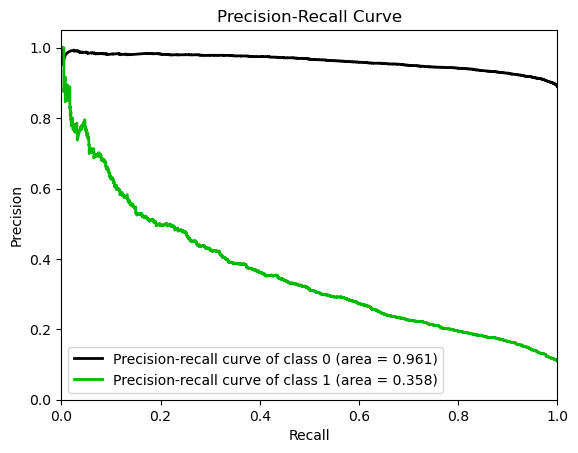

In [16]:
plot_precision_recall_curve(y_test, y_pred, curves='each_class')

<Axes: title={'center': 'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

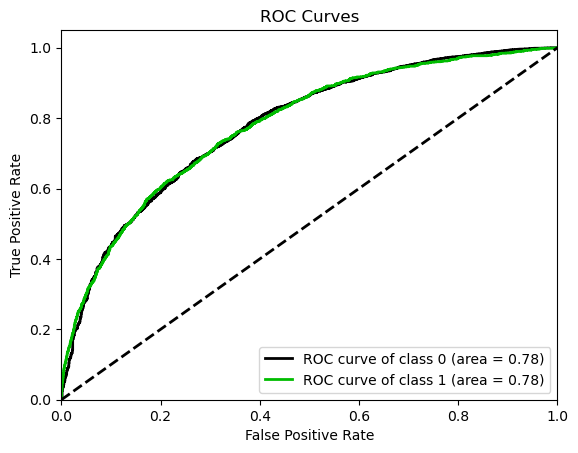

In [17]:
plot_roc_curve(y_test, y_pred, curves='each_class')

### *Interpret the calibration curve*

<Axes: title={'center': 'Calibration plots (Reliability Curves)'}, xlabel='Mean predicted value', ylabel='Fraction of positives'>

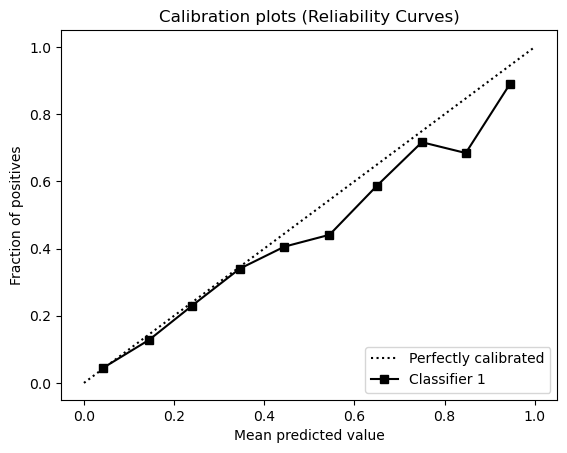

In [18]:
plot_calibration_curve(y_test, [y_pred])